## 01. Import Libraries & Data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'bDLK7GgXF-eGpXEefy26'

In [3]:
# Importing the Consumer Price Index - Canada "Inflation Rates" variable.

data = quandl.get('RATEINF/CPI_CAN')

In [4]:
data.head(5)

,Value
Date,
1989-01-31,72.7
1989-02-28,73.2
1989-03-31,73.6
1989-04-30,73.8
1989-05-31,74.6


In [5]:
# Importing the correct variable...

data = quandl.get('RATEINF/INFLATION_CAN')

In [6]:
data.head(5)

,Value
Date,
1990-01-31,5.5
1990-02-28,5.5
1990-03-31,5.3
1990-04-30,5.0
1990-05-31,4.4


In [7]:
data.shape

(401, 1)

In [8]:
data.columns

Index(['Value'], dtype='object')

## 02. Subsetting, Wrangling, and Cleaning Time-Series Data

In [9]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,1990-01-31,5.5
1,1990-02-28,5.5
2,1990-03-31,5.3
3,1990-04-30,5.0
4,1990-05-31,4.4


In [11]:
data_sub = data_2.loc[(data_2['Date'] >= '2006-01-01') & (data_2['Date'] < '2016-01-01')]

In [12]:
data_sub.shape

(120, 2)

In [13]:
data_sub.head()

,Date,Value
192,2006-01-31,2.8
193,2006-02-28,2.2
194,2006-03-31,2.2
195,2006-04-30,2.4
196,2006-05-31,2.8


In [14]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2006-01-31,2.8
2006-02-28,2.2
2006-03-31,2.2
2006-04-30,2.4
2006-05-31,2.8


I created a subset of the data for dates between 2006 and 2015 because the dataset of my final project has records of employees from 2006 to 2015. I am curious to know how inflation rate may have impacted layoffs or employee attrition at the time (if any impact at all).

## 03. Line Chart

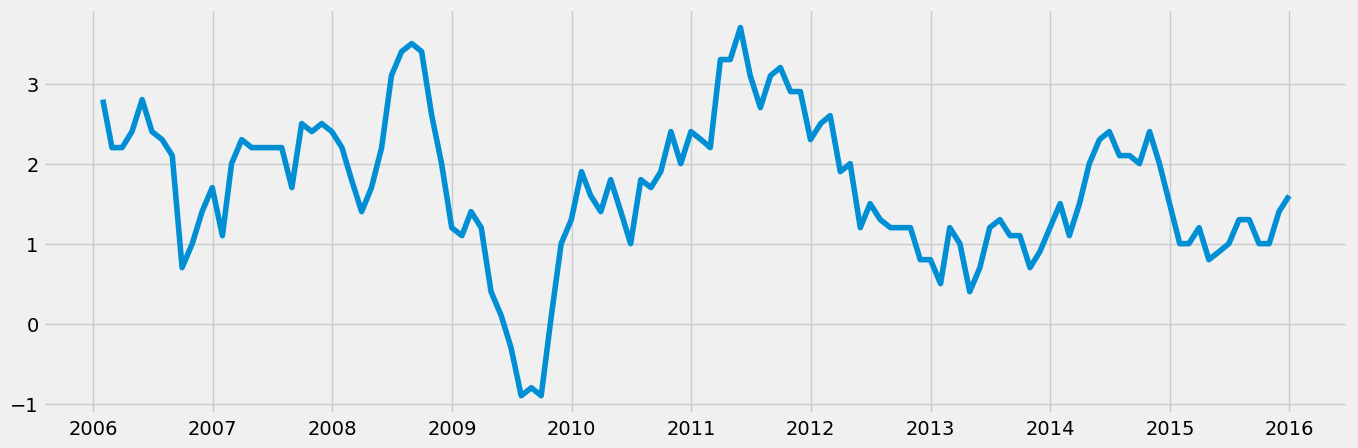

In [15]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

## 04. Decomposition

In [16]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [17]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

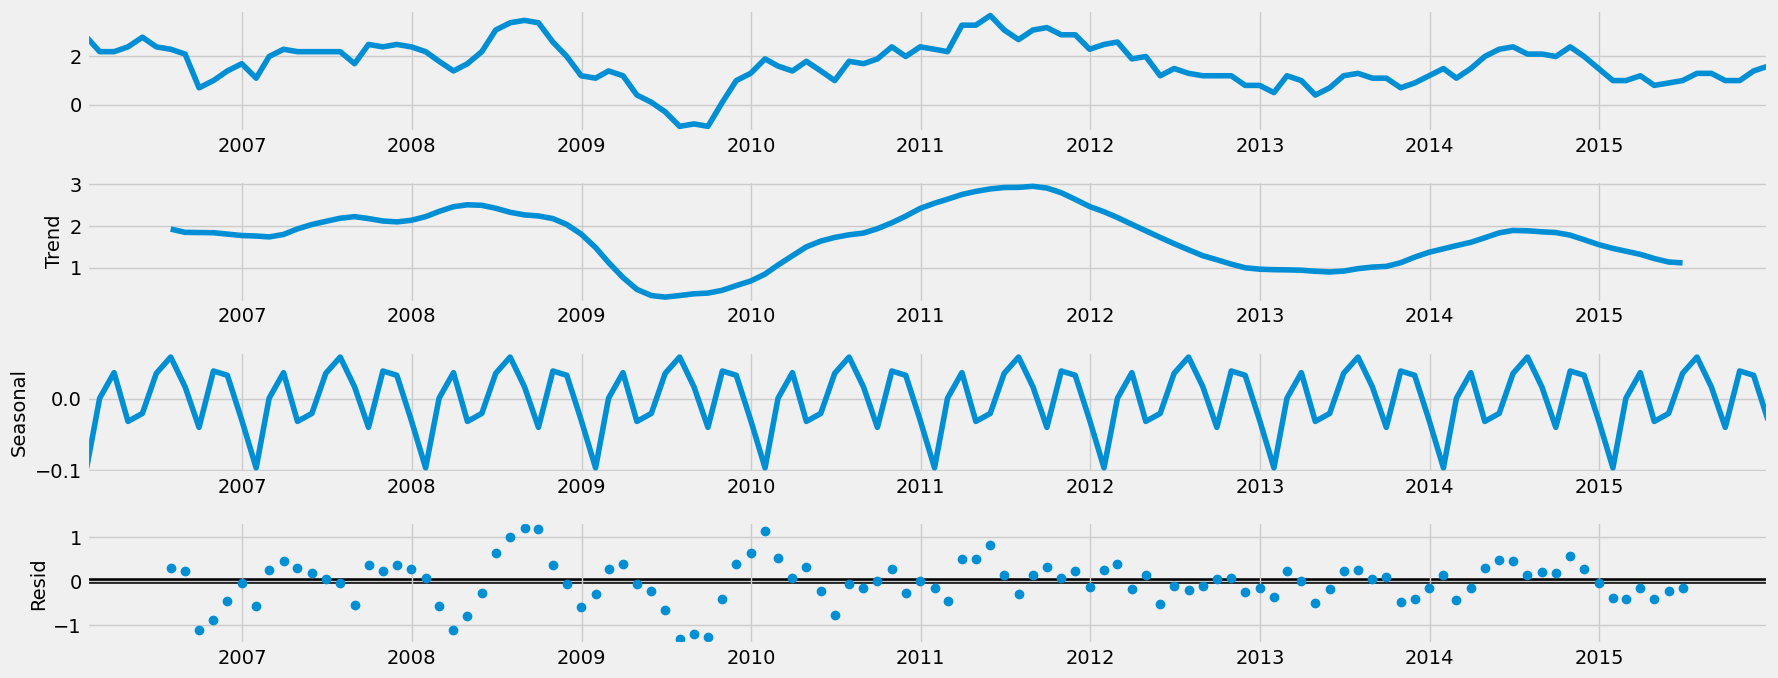

In [18]:
# Plot the separate components

decomposition.plot()
plt.show()

The first chart at the top is the data itself with all of its components (Level).

The second chart shows the underlying trend. The level and underlying trend appear to be similar / the same. This is because this data doesn't have much noise and therefore doesn't need to be smoothed. The trend drops starting in 2008, reaching a low in 2009 and then increasing until 2011, when it drops again, reaching another low point in 2013. The inflation rate seems to fluctuate, with the two high points having around a 3 year gap and the two low points having around a 4 year gap.

The third chart shows seasonality - there appear to be seasonal fluctuations every year, with the inflation rate at its lowest at the beginning of the year. 

The bottom chart shows noise, or residual. There does seem to be some residual noise but since the level and underlying trend follow the same trend, this noise can be explained by the everyday volatility of the market.

## 05. Stationarity Testing

In [19]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.165357
p-value                          0.219058
Number of Lags Used             12.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


I need to compare test statistic to the critical value of the corresponding significance level. I am looking to disprove the null hypothesis, so the test statistic should be smaller than the critical value in order to reject the null hypothesis.

Using a significance level of 5%, the test statistic (-2.2) is greater than the critical value of -2.9, so I can't reject the null hypothesis. There is a unit root in the data and the data is non-stationary.

## 06. Stationarizing the Data using Differencing

In [20]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [21]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [22]:
data_diff.head()

,Value
datetime,
2006-02-28,-0.6
2006-03-31,0.0
2006-04-30,0.2
2006-05-31,0.4
2006-06-30,-0.4


In [23]:
data_diff.columns

Index(['Value'], dtype='object')

In [24]:
# Checking what the differencing did - running Dickey-Fuller Stationarity test
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.808967
p-value                          0.000052
Number of Lags Used             11.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


Using a significance level of 5%, the test statistic (-4.8) is now less than the critical value (-2.9) as well as the critical value at the 10% significance level (-2.6). In addition, the p-value is less than 0.05.

I can reject the null hypothesis and consider the time series stationary.

## 07. Autocorrelation

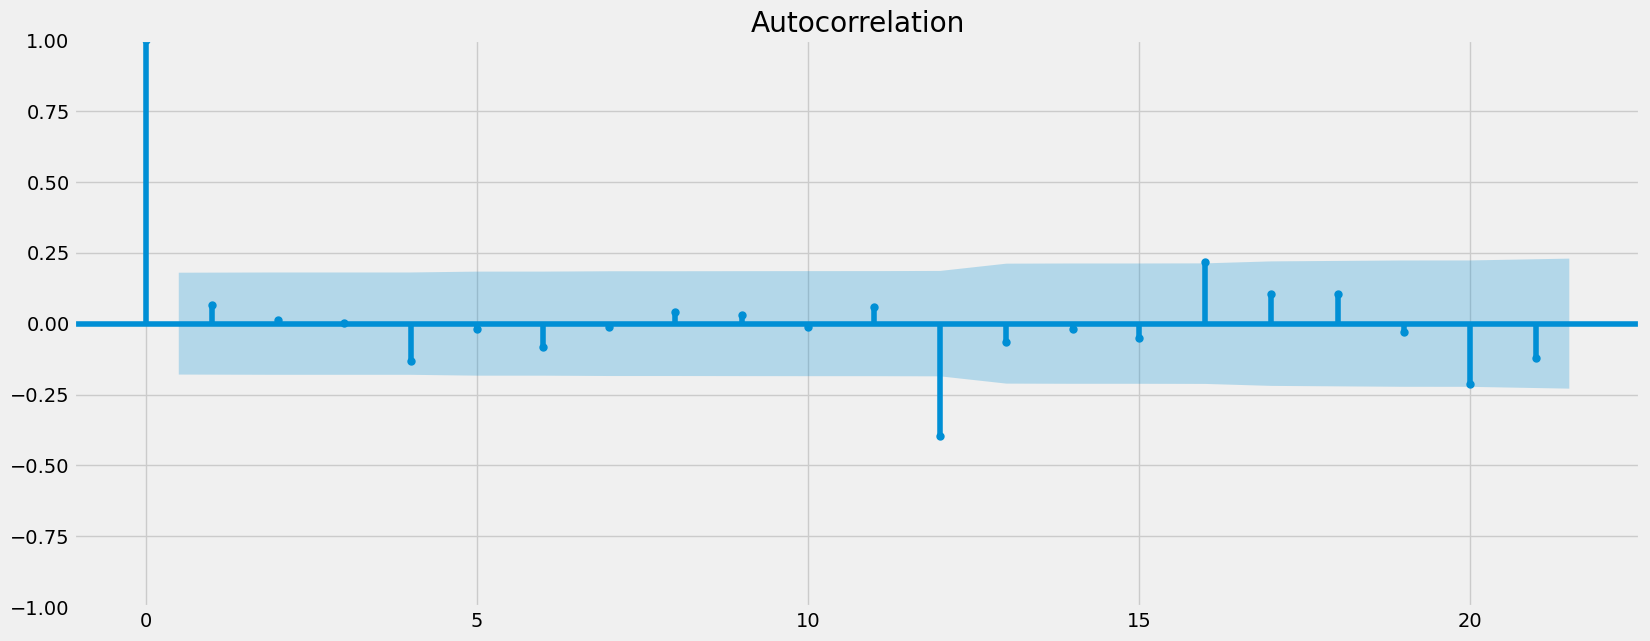

In [25]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_diff)
plt.show()

Not many lines (lags in the series) go above the blue edge of the confidence interval, so I can consider the data to be stationary.